# Keras costs visualizations
In this notebook we will visualize different costs associated with different popular architectures

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import json
report_paths = ["timings/dummy_linear_time_ns.timings.json", "timings/dummy_linear_thread_time_ns.timings.json"]
reports = list()
for path in report_paths:
    with open(path) as file:
        reports.append(json.load(file))

### Layer wise costs

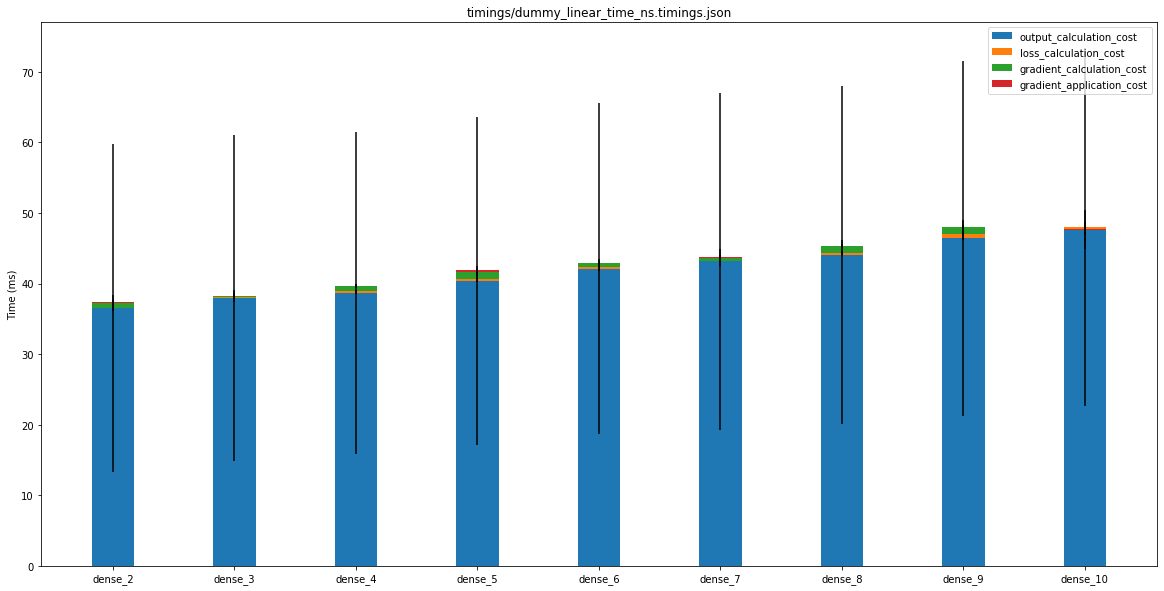

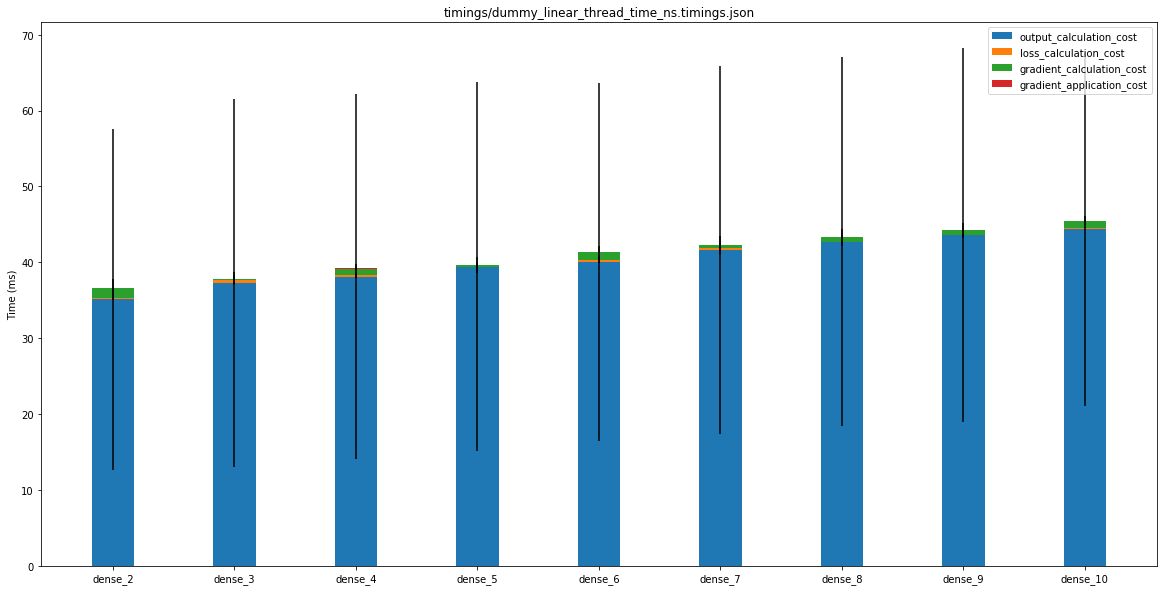

In [40]:
skip_first_layer = True # First layer is usually an outlier
for i, report in enumerate(reports):
    timings = report["timings"]
    N = len(timings) - (1 if skip_first_layer else 0)
    normalizing_factor = report["args"]["samples"] * 10**6 # Milliseconds instead of nano seconds
    means = dict()
    stds = dict()
    xticks = list()
    for layer_name in list(timings.keys())[(1 if skip_first_layer else 0):]:
        for cost_name in timings[layer_name].keys():
            if not cost_name.endswith("cost"):
                continue
            if cost_name not in means.keys():
                means[cost_name] = list()
            if cost_name not in stds.keys():
                stds[cost_name] = list()
            data = np.array(timings[layer_name][cost_name]) / normalizing_factor
            means[cost_name].append(np.mean(data))
            stds[cost_name].append(np.std(data))
        xticks.append(layer_name)

    plt.figure(figsize=(20,10))
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence
    accumulated_means = np.zeros(shape=N)
    for cost in means.keys():
        p = plt.bar(ind, means[cost], width, yerr=stds[cost], bottom=accumulated_means, label=cost)
        accumulated_means += means[cost]

    plt.ylabel('Time (ms)')
    plt.title(report_paths[i])
    plt.xticks(ind, xticks)
    plt.legend()
    plt.show()


### Layer type wise costs